<a id='top'></a>

# Shot Maps using Data from Understat
##### Notebook on how to scrape raw data from [Understat.com](https://understat.com/) to produce shot maps.

### By [Edd Webster](https://www.twitter.com/eddwebster)
Last updated: 26/07/2020

![title](../../img/understat-logo-banner.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook is a short Exploratory Data Analysis (EDA) of scraped football statistics data from [FBref.com](https://fbref.com/en/), provided by [StatsBomb](https://statsbomb.com/), and [TransferMarkt](https://www.transfermarkt.co.uk/), using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames, [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) for webscraping, [RecordLinkage](https://pypi.org/project/recordlinkage/) to join the fuzzy data sets, and [matplotlib](https://matplotlib.org/) to create custom visualisations.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/),
*    edd.j.webster@gmail.com,
*    [@eddwebster](https://www.twitter.com/eddwebster),
*    [LinkedIn.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/),
*    [GitHub/eddwebster](https://github.com/eddwebster/),
*    [Kaggle.com/eddwebster](https://www.kaggle.com/eddwebster), and
*    [HackerRank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](img/fifa20eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/fifa-league) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/fifa-league/blob/master/FIFA%2020%20Fantasy%20Football%20League%20using%20TransferMarkt%20Player%20Valuations.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br> 
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    `tqdm` for a clean progress bar;
*    `requests` for executing HTTP requests;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping;
*    [`RecordLinkage`](https://pypi.org/project/recordlinkage/) for joining of fuzzy datasets; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [50]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Date and Time manipulation
import datetime
from datetime import datetime

# Data Preprocessing
import pandas as pd    # version 1.0.3
import os    #  used to read the csv filenames
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re


# Football Libraries
from FCPython import createPitch

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno    # visually display missing data

# Machine Learning
import scipy as sp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import brier_score_loss, roc_auc_score    # version 0.22
from xgboost import XGBClassifier   # version 1.0.2

# Progress Bar
from tqdm import tqdm    # a clean progress bar library

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print("Setup Complete")

Setup Complete


In [4]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('SciPy: {}'.format(sp.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0
SciPy: 1.4.1


### Defined Variables and Lists

In [48]:
#Size of the pitch in yards (!!!)
pitchLengthX=120
pitchWidthY=80

### Define Data Paths

In [6]:
# Set up initial paths to subfolders
base_dir = os.path.join('.')
data_dir = os.path.join(base_dir, 'data')
data_dir_fbref = os.path.join(base_dir, 'data', 'fbref')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [68]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to create shot maps from data scraped from [Understat.com](https://understat.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames, [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) for webscraping and [matplotlib](https://matplotlib.org/) to create custom visualisations. 

This notebooks produces CSV files of shot data that can be further analysis using Python (see [Section 5](#section5) of this notebook), or can be explored using Tableau, PowerBI, Microsoft Excel. These datasets are the following.

These [Understat.com](https://understat.com/) webscraper is available in both Python and R. The R version was written by [Euan Dewar]() and is available in his GitHub repository [here](https://github.com/ewenme/understatr). The Python version was written by [Amos Bastian](https://github.com/amosbastian) and is available in his GitHub repository [here](https://github.com/amosbastian/understat). The official documentation for Amos' Understat package can be found [here](https://understat.readthedocs.io/en/latest/).

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and Cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2.'>3.2. Data Dictionary</a>
The raw dataset has one hundred and eighty eight features (columns) with the following definitions and data types:

| Variable     | Data Type    | Description    |
|------|-----|-----|
| `squad`    | object    | Squad name e.g. Arsenal    |
| `players_used`    | float64    | Number of Players used in Games    |
| `possession`    | float64    | Percentage of time with possession of the ball    |
| `games`    | float64    | <b>Matches Played</b>. Matches Played by the player or squad    |
| `games_starts`    | float64    | <b>Starts</b>. Game or games started by player    |

<br>
The features will be cleaned, converted and also additional features will be created in the [Data Engineering](#section4) section (Section 4).

In [137]:
df_liverpool_2019 = pd.read_csv(data_dir + '/Liverpool2019shots.csv')

### <a id='#section3.2.'>3.3. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [10]:
# Display the first 5 rows of the raw DataFrame, df_fbref_team_top5_1920_raw
df_liverpool_2019.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,309898,18,Goal,0.933,0.367,0.366817,Mohamed Salah,h,1250,OpenPlay,2019,LeftFoot,11643,Liverpool,Norwich,4,1,2019-08-09 20:00:00,Roberto Firmino,Pass
1,309908,53,MissedShots,0.880,0.339,0.077992,Mohamed Salah,h,1250,OpenPlay,2019,LeftFoot,11643,Liverpool,Norwich,4,1,2019-08-09 20:00:00,Fabinho,BallRecovery
2,310445,32,MissedShots,0.939,0.721,0.041742,Mohamed Salah,a,1250,OpenPlay,2019,LeftFoot,11658,Southampton,Liverpool,1,2,2019-08-17 15:00:00,Alex Oxlade-Chamberlain,Chipped
3,310449,49,BlockedShot,0.801,0.310,0.071200,Mohamed Salah,a,1250,DirectFreekick,2019,LeftFoot,11658,Southampton,Liverpool,1,2,2019-08-17 15:00:00,NaN,Standard
4,310454,55,SavedShot,0.923,0.357,0.300783,Mohamed Salah,a,1250,OpenPlay,2019,LeftFoot,11658,Southampton,Liverpool,1,2,2019-08-17 15:00:00,Sadio Mané,Chipped


In [11]:
# Display the last 5 rows of the raw DataFrame, df_liverpool_2019 
df_liverpool_2019.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
555,369038,85,MissedShots,0.690,0.454,0.016793,Curtis Jones,h,6665,OpenPlay,2019,LeftFoot,11966,Liverpool,Aston Villa,2,0,2020-07-05 15:30:00,Georginio Wijnaldum,Pass
556,369039,88,Goal,0.912,0.449,0.380632,Curtis Jones,h,6665,OpenPlay,2019,RightFoot,11966,Liverpool,Aston Villa,2,0,2020-07-05 15:30:00,Mohamed Salah,HeadPass
557,370418,16,SavedShot,0.869,0.551,0.095451,Curtis Jones,h,6665,OpenPlay,2019,LeftFoot,11986,Liverpool,Burnley,1,1,2020-07-11 14:00:00,Roberto Firmino,Pass
558,370420,20,BlockedShot,0.868,0.530,0.112289,Curtis Jones,h,6665,OpenPlay,2019,RightFoot,11986,Liverpool,Burnley,1,1,2020-07-11 14:00:00,Sadio Mané,Pass
559,370429,50,MissedShots,0.855,0.581,0.129922,Curtis Jones,h,6665,OpenPlay,2019,LeftFoot,11986,Liverpool,Burnley,1,1,2020-07-11 14:00:00,Mohamed Salah,Pass


[shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) returns a tuple representing the dimensionality of the DataFrame.

In [12]:
# Print the shape of the raw DataFrame, df_fbref_team_top5_1920_raw
print(df_liverpool_2019.shape)

(560, 20)


The raw DataFrame has:
*    744 observations (rows), each observation represents one individual tourist stranded in Peru, and
*    20 attributes (columns).

[columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns the column labels of the DataFrame.

In [13]:
# Features (column names) of the raw DataFrame, ddf_liverpool_2019 
df_liverpool_2019.columns

Index(['id', 'minute', 'result', 'X', 'Y', 'xG', 'player', 'h_a', 'player_id',
       'situation', 'year', 'shotType', 'match_id', 'h_team', 'a_team',
       'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction'],
      dtype='object')

The [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) method returns the data types of each attribute in the DataFrame.

In [14]:
# Data types of the features of the raw DataFrame, df_liverpool_2019
df_liverpool_2019.dtypes

id                   int64
minute               int64
result              object
X                  float64
Y                  float64
xG                 float64
player              object
h_a                 object
player_id            int64
situation           object
year                 int64
shotType            object
match_id             int64
h_team              object
a_team              object
h_goals              int64
a_goals              int64
date                object
player_assisted     object
lastAction          object
dtype: object

In [15]:
# Displays all one hundered and four columns, commented out but shown for reference
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_liverpool_2019.dtypes)

id                   int64
minute               int64
result              object
X                  float64
Y                  float64
xG                 float64
player              object
h_a                 object
player_id            int64
situation           object
year                 int64
shotType            object
match_id             int64
h_team              object
a_team              object
h_goals              int64
a_goals              int64
date                object
player_assisted     object
lastAction          object
dtype: object


The [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) method to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [16]:
# Info for the raw DataFrame, df_liverpool_2019
df_liverpool_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               560 non-null    int64  
 1   minute           560 non-null    int64  
 2   result           560 non-null    object 
 3   X                560 non-null    float64
 4   Y                560 non-null    float64
 5   xG               560 non-null    float64
 6   player           560 non-null    object 
 7   h_a              560 non-null    object 
 8   player_id        560 non-null    int64  
 9   situation        560 non-null    object 
 10  year             560 non-null    int64  
 11  shotType         560 non-null    object 
 12  match_id         560 non-null    int64  
 13  h_team           560 non-null    object 
 14  a_team           560 non-null    object 
 15  h_goals          560 non-null    int64  
 16  a_goals          560 non-null    int64  
 17  date            

The [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to show some useful statistics for each numerical column in the DataFrame.

In [17]:
# Description of the raw DataFrame, df_liverpool_2019, showing some summary statistics for each numberical column in the DataFrame
df_liverpool_2019.describe()

,id,minute,X,Y,xG,player_id,year,match_id,h_goals,a_goals
count,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.0,560.000000,560.000000,560.000000
mean,341874.573214,47.614286,0.860796,0.494675,0.132805,1151.864286,2019.0,11822.441071,1.839286,1.294643
std,19327.312427,24.653835,0.075663,0.116142,0.168016,965.000279,0.0,108.550328,1.406308,1.027688
min,309897.000000,0.000000,0.033000,0.236000,0.000000,332.000000,2019.0,11643.000000,0.000000,0.000000
25%,327616.500000,29.000000,0.813000,0.406000,0.034975,605.000000,2019.0,11734.250000,1.000000,1.000000
50%,339682.500000,48.000000,0.873000,0.497000,0.071777,838.000000,2019.0,11822.000000,2.000000,1.000000
75%,353156.250000,65.000000,0.912000,0.573500,0.119776,1250.000000,2019.0,11911.000000,3.000000,2.000000
max,373322.000000,95.000000,0.989000,0.847000,0.934837,6665.000000,2019.0,12006.000000,5.000000,4.000000


Next, we will check to see how many missing values we have i.e. the number of NULL values in the dataset, and in what features these missing values are located. This can be plotted nicely using the [missingno](https://pypi.org/project/missingno/) library (pip install missingno).

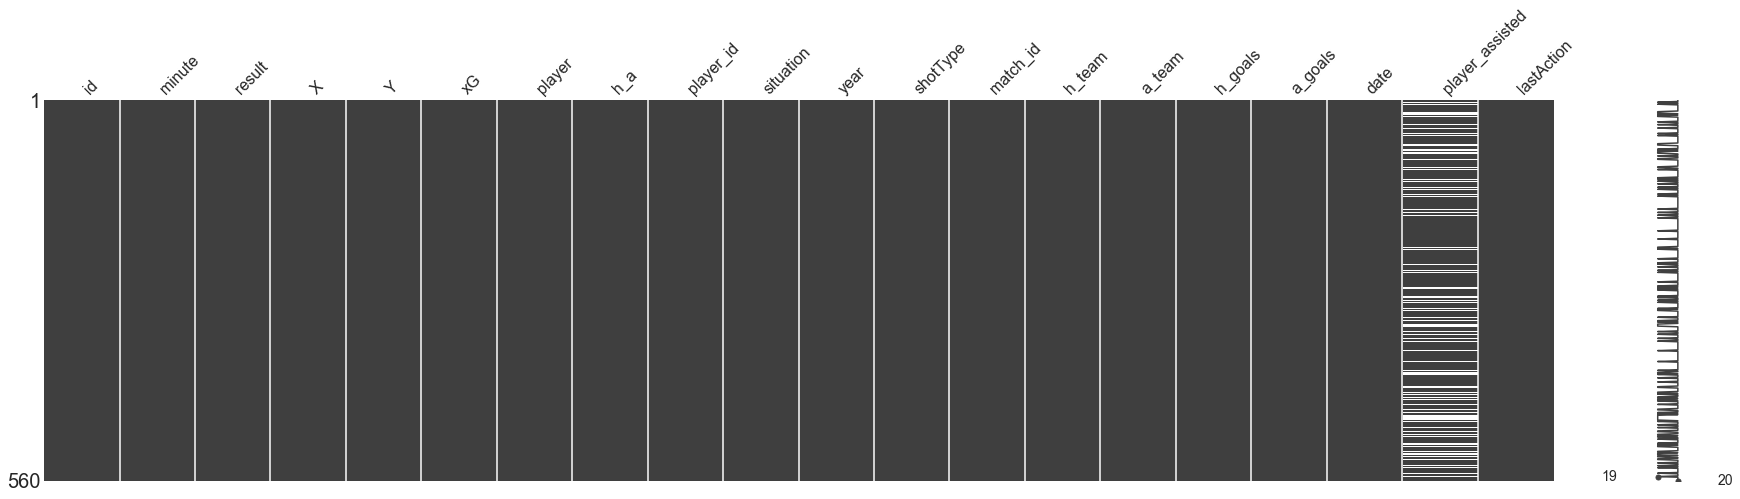

In [18]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_liverpool_2019
msno.matrix(df_liverpool_2019, figsize = (30, 7))

In [19]:
# Counts of missing values
null_value_stats = df_liverpool_2019.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

player_assisted    132
dtype: int64

The visualisation shows us very quickly that there are only missing values for `player_assisted` which represents shots that had no assist.

## <a id='#section4'>4. Data Engineering</a>

### <a id='#section4.1'>4.1. Introduction</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean, wrangle, and join the two datasets to be in a form that meet our needs.

These two data sources are joined to create a single DataFrame in section 4.4 before going on to be analysed in section 5.

### <a id='#section4.2.'>4.2. String Cleaning</a>
...

### <a id='#section4.3'>4.3. Export DataFrame</a>

In [20]:
# df_liverpool_2019.to_csv(data_dir_fbref + '/engineered/goalkeeper/' + 'goalkeeper_big5_1920_engineered_{}.csv'.format(datetime.datetime.now().strftime("%d%m%Y-%H%M")), index=None, header=True)

## <a id='#section5'>5. Exploratory Data Analysis</a>

### <a id='#section5.1'>5.1. Introduction</a>
...

### <a id='#section5.2'>5.2. Shot Maps</a>

#### <a id='#section5.2.1'>5.2.1. X,Y Conversion and Pitch Measurements</a>
Convert Understats coordinates from 0,100 to a range of x(0,104) and y(0,68) - the average pitch size.

If you have access to the data and know the exact dimensions for pitches in the leagues you are interested in, you could make this even more accurate.

In [138]:
pitch_length_x = 104
pitch_length_y = 68

In [157]:
# Add new columns

## Convert Understats coordinates from 0,100 to a range of x(0,104) and y(0,68) - the average pitch size.
df_liverpool_2019['XM'] = df_liverpool_2019['X'] * pitch_length_x
df_liverpool_2019['YM'] = df_liverpool_2019['Y'] * pitch_length_y

## Create reverse columns of previous created 'XM' and 'YM' columns
df_liverpool_2019['XM_r'] = pitch_length_x - df_liverpool_2019['XM']    # Added for completeness but not used
df_liverpool_2019['YM_r'] = pitch_length_y - df_liverpool_2019['YM']

## Create column of scaled xG to make them larger in the plot
df_liverpool_2019['xG_s'] = df_liverpool_2019['xG'] * 1.5

In [158]:
df_liverpool_2019.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,...,h_goals,a_goals,date,player_assisted,lastAction,XM,YM,XM_r,YM_r,xG_s
0,309898,18,Goal,0.933,0.367,0.366817,Mohamed Salah,h,1250,OpenPlay,...,4,1,2019-08-09 20:00:00,Roberto Firmino,Pass,97.032003,24.956001,6.967997,43.043999,0.550225
1,309908,53,MissedShots,0.880,0.339,0.077992,Mohamed Salah,h,1250,OpenPlay,...,4,1,2019-08-09 20:00:00,Fabinho,BallRecovery,91.520000,23.052001,12.480000,44.947999,0.116988
2,310445,32,MissedShots,0.939,0.721,0.041742,Mohamed Salah,a,1250,OpenPlay,...,1,2,2019-08-17 15:00:00,Alex Oxlade-Chamberlain,Chipped,97.656002,49.027999,6.343998,18.972001,0.062613
3,310449,49,BlockedShot,0.801,0.310,0.071200,Mohamed Salah,a,1250,DirectFreekick,...,1,2,2019-08-17 15:00:00,NaN,Standard,83.303998,21.080000,20.696002,46.920000,0.106800
4,310454,55,SavedShot,0.923,0.357,0.300783,Mohamed Salah,a,1250,OpenPlay,...,1,2,2019-08-17 15:00:00,Sadio Mané,Chipped,95.992003,24.276001,8.007997,43.723999,0.451174


#### <a id='#section5.2.2'>5.2.2. Unique Players by ID</a>

In [159]:
df_liverpool_2019['player'].unique()

array(['Mohamed Salah', 'Sadio Mané', 'Roberto Firmino',
       'Jordan Henderson', 'Georginio Wijnaldum', 'Virgil van Dijk',
       'Alex Oxlade-Chamberlain', 'Trent Alexander-Arnold',
       'Divock Origi', 'James Milner', 'Andrew Robertson', 'Fabinho',
       'Naby Keita', 'Joel Matip', 'Adam Lallana', 'Xherdan Shaqiri',
       'Curtis Jones'], dtype=object)

In [160]:
df_salah = df_liverpool_2019.loc[df_liverpool_2019['player'] == 'Mohamed Salah'].set_index('id')

In [161]:
df_salah.head()

,minute,result,X,Y,xG,player,h_a,player_id,situation,year,...,h_goals,a_goals,date,player_assisted,lastAction,XM,YM,XM_r,YM_r,xG_s
id,,,,,,,,,,,,,,,,,,,,,
309898,18,Goal,0.933,0.367,0.366817,Mohamed Salah,h,1250,OpenPlay,2019,...,4,1,2019-08-09 20:00:00,Roberto Firmino,Pass,97.032003,24.956001,6.967997,43.043999,0.550225
309908,53,MissedShots,0.880,0.339,0.077992,Mohamed Salah,h,1250,OpenPlay,2019,...,4,1,2019-08-09 20:00:00,Fabinho,BallRecovery,91.520000,23.052001,12.480000,44.947999,0.116988
310445,32,MissedShots,0.939,0.721,0.041742,Mohamed Salah,a,1250,OpenPlay,2019,...,1,2,2019-08-17 15:00:00,Alex Oxlade-Chamberlain,Chipped,97.656002,49.027999,6.343998,18.972001,0.062613
310449,49,BlockedShot,0.801,0.310,0.071200,Mohamed Salah,a,1250,DirectFreekick,2019,...,1,2,2019-08-17 15:00:00,NaN,Standard,83.303998,21.080000,20.696002,46.920000,0.106800
310454,55,SavedShot,0.923,0.357,0.300783,Mohamed Salah,a,1250,OpenPlay,2019,...,1,2,2019-08-17 15:00:00,Sadio Mané,Chipped,95.992003,24.276001,8.007997,43.723999,0.451174


In [162]:
df_salah.shape

(129, 24)

In [163]:
import datetime

In [164]:
df_salah.to_csv(data_dir + '/liverpool_2010_salah_{}.csv'.format(datetime.datetime.now().strftime("%d%m%Y-%H%M")), index=None, header=True)

#### <a id='#section5.2.2'>5.2.2. Plot Events</a>

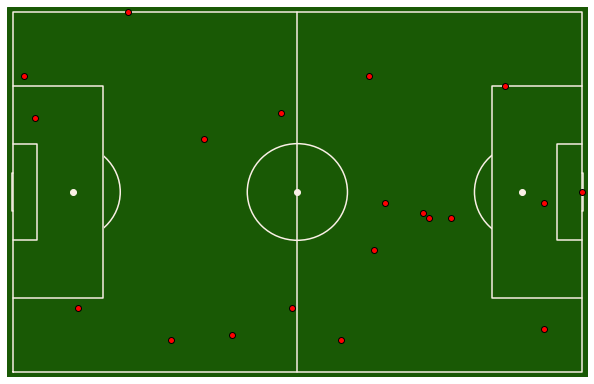

In [165]:
## generate random data

import random

sample = 20

draw_pitch("#195905","#faf0e6","horizontal","full")

x = [random.randint(0, pitch_length_x) for p in range(0, sample)]
y = [random.randint(0, pitch_length_y) for p in range(0,sample)]

zo = 12

plt.scatter(x,y,marker='o',color='red',edgecolors="black", zorder=zo)
plt.show()

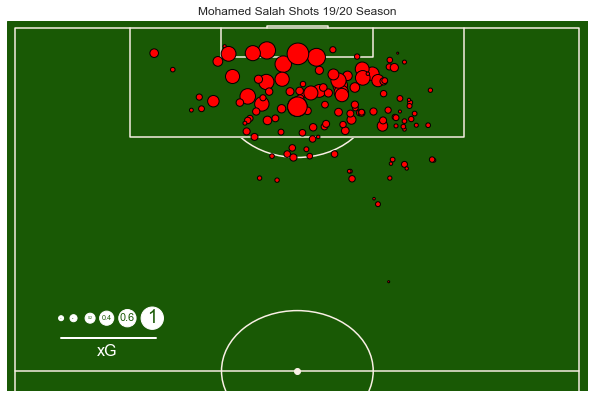

In [182]:
# Plotting Shots

## Draw the pitch
draw_pitch("#195905","#faf0e6","vertical","half")


## X and Y coordinates
x = df_salah['XM'].tolist()
y = df_salah['YM'].tolist()
# x = [random.randint(72, 104) for p in range(0, sample)]
# y = [random.randint(10,58) for p in range(0,sample)]
y1 = [68 - i for i in y]


## Add Z variable for xG
z = df_salah['xG'].tolist()
#z = [random.uniform(0,1) for p in range(0,sample)]
z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting


## Add small legend in the bottom corner
mSize = [0.05,0.10,0.2,0.4,0.6,1]
mSizeS = [500 * i for i in mSize]
mx = [5.5,7,9,11,13.5,16.5]
my = [60,60,60,60,60,60]

plt.text(11,55,"xG", color="white", ha="center",va="center", zorder=zo, fontsize=16)
plt.scatter(y1,x,s=z1, c="red",edgecolors="k",zorder=zo)
plt.scatter(mx,my,s=mSizeS,facecolors="white", edgecolor="white",zorder=zo)
plt.plot([5.5,17], [57,57],color="white",lw=2,zorder=zo)

i = 0

for i in range(len(mx)):
    plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color="#195905", zorder=zo,ha="center", va="center")

    
## Title
plt.title("Mohamed Salah Shots 19/20 Season")

## Show plot
plt.show()

In [167]:
hHead = df_salah[df_salah['shotType'] == 'Head']
hFoot = df_salah[df_salah['shotType'] != 'Head']

In [168]:
hHead.head()

,minute,result,X,Y,xG,player,h_a,player_id,situation,year,...,h_goals,a_goals,date,player_assisted,lastAction,XM,YM,XM_r,YM_r,xG_s
id,,,,,,,,,,,,,,,,,,,,,
312724,55,MissedShots,0.947,0.525,0.542652,Mohamed Salah,h,1250,OpenPlay,2019,...,3,1,2019-08-24 17:30:00,Andrew Robertson,Cross,98.487997,35.700000,5.512003,32.300000,0.813979
329257,64,MissedShots,0.968,0.437,0.075641,Mohamed Salah,a,1250,OpenPlay,2019,...,1,2,2019-11-02 15:00:00,NaN,Aerial,100.672003,29.716001,3.327997,38.283999,0.113462
331548,12,Goal,0.913,0.398,0.184657,Mohamed Salah,h,1250,OpenPlay,2019,...,3,1,2019-11-10 16:30:00,Andrew Robertson,Cross,94.952003,27.063999,9.047997,40.936001,0.276986
335676,26,SavedShot,0.963,0.322,0.008257,Mohamed Salah,a,1250,OpenPlay,2019,...,0,3,2019-12-07 15:00:00,Joseph Gomez,Cross,100.152003,21.896001,3.847997,46.103999,0.012386
352364,72,MissedShots,0.908,0.496,0.114547,Mohamed Salah,a,1250,OpenPlay,2019,...,0,2,2020-01-29 19:45:00,Trent Alexander-Arnold,Cross,94.432003,33.727999,9.567997,34.272001,0.171820


In [169]:
df_salah['result'].unique()

array(['Goal', 'MissedShots', 'BlockedShot', 'SavedShot', 'ShotOnPost'],
      dtype=object)

In [170]:
hHGoal = hHead[hHead['result'] == "Goal"]
hHMissed = hHead[hHead['result'] == "MissedShots"]
hHBlocked = hHead[hHead['result'] == "BlockedShot"]
hHSaved = hHead[hHead['result'] == "SavedShot"]
hHPost = hHead[hHead['result'] == "ShotOnPost"]

In [171]:
hFGoal = hFoot[(hFoot['result'] == "Goal") & (hFoot['situation'] == "DirectFreekick")]
hFKGoal = hFoot[(hFoot['result'] == "Goal") & (hFoot['situation'] == "DirectFreekick")]

hFMissed = hFoot[(hFoot['result'] == "MissedShots") & (hFoot['situation'] != "DirectFreekick")]
hFKMissed = hFoot[(hFoot['result'] == "MissedShots") & (hFoot['situation'] == "DirectFreekick")]

hFBlocked = hFoot[(hFoot['result'] == "BlockedShot") & (hFoot['situation'] != "DirectFreekick")]
hFKBlocked = hFoot[(hFoot['result'] == "BlockedShot") & (hFoot['situation'] == "DirectFreekick")]

hFSaved = hFoot[(hFoot['result'] == "SavedShot") & (hFoot['situation'] != "DirectFreekick")]
hFKSaved = hFoot[(hFoot['result'] == "SavedShot") & (hFoot['situation'] == "DirectFreekick")]

hFPost= hFoot[(hFoot['result'] == "ShotOnPost") & (hFoot['situation'] != "DirectFreekick")]
hFKPost = hFoot[(hFoot['result'] == "ShotOnPost") & (hFoot['situation'] == "DirectFreekick")]

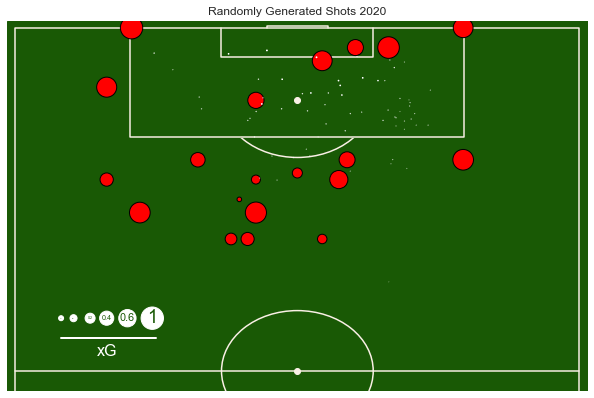

In [176]:
# Plotting Shots

## Draw the pitch
draw_pitch("#195905","#faf0e6","vertical","half")


## X and Y coordinates
x = [random.randint(72, 104) for p in range(0, sample)]
y = [random.randint(10,58) for p in range(0,sample)]
y1 = [68 - i for i in y]


## Add Z variable for xG
z = [random.uniform(0,1) for p in range(0,sample)]
z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting


## Add small legend in the bottom corner
mSize = [0.05,0.10,0.2,0.4,0.6,1]
mSizeS = [500 * i for i in mSize]
mx = [5.5,7,9,11,13.5,16.5]
my = [60,60,60,60,60,60]

plt.text(11,55,"xG", color="white", ha="center",va="center", zorder=zo, fontsize=16)
plt.scatter(y1,x,s=z1, c="red",edgecolors="k",zorder=zo)
plt.scatter(mx,my,s=mSizeS,facecolors="white", edgecolor="white",zorder=zo)
plt.plot([5.5,17], [57,57],color="white",lw=2,zorder=zo)

i = 0

for i in range(len(mx)):
    plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color="#195905", zorder=zo,ha="center", va="center")

    
##
if len(hFGoal) > 0:
    plt.scatter(hFGoal.YM_r, hFGoal.XM,
    s=hFGoal.xG_s,marker='H',#c=hFGoal.colors,
    edgecolors="white",zorder=zo)
    plt.scatter(hFGoal.YM_r, hFGoal.XM,
    s=hFGoal.xG*2000,marker='H',facecolors="none",
    edgecolors="white",zorder=zo+1)
    
if len(hFMissed) > 0:
    plt.scatter(hFMissed.YM_r, hFMissed.XM,
    s=hFMissed.xG_s,marker='H',facecolors="none",
    edgecolors="white",zorder=zo)

if len(hFSaved) > 0:
    plt.scatter(hFSaved.YM_r, hFSaved.XM,
    s=hFSaved.xG_s,marker='H',#c=hFSaved.colors,
    edgecolors="white",zorder=zo)
    
## Title
plt.title("Randomly Generated Shots 2020")

## Show plot
plt.show()

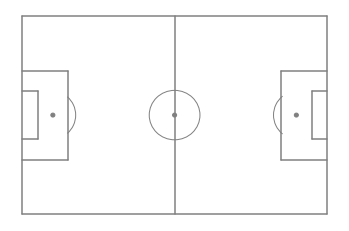

In [61]:
# Draw the pitch
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')

In [62]:
shots = df_salah

In [63]:
shots.iloc[0]

minute                              18
result                            Goal
X                                0.933
Y                                0.367
xG                            0.366817
player                   Mohamed Salah
h_a                                  h
player_id                         1250
situation                     OpenPlay
year                              2019
shotType                      LeftFoot
match_id                         11643
h_team                       Liverpool
a_team                         Norwich
h_goals                              4
a_goals                              1
date               2019-08-09 20:00:00
player_assisted        Roberto Firmino
lastAction                        Pass
Name: 309898, dtype: object

In [56]:
# Plot the shots
for i,shot in shots.iterrows():
    x=shot['X'][0]
    y=shot['Y'][1]
    
    goal=shot['result']=='Goal'
    team_name=shot['team_name']
    
    circleSize=2
    #circleSize=np.sqrt(shot['shot_statsbomb_xg']*15)

    if (team_name==home_team_required):
        if goal:
            shotCircle=plt.Circle((x,pitchWidthY-y),circleSize,color="red")
            plt.text((x+1),pitchWidthY-y+1,shot['player']) 
        else:
            shotCircle=plt.Circle((x,pitchWidthY-y),circleSize,color="red")     
            shotCircle.set_alpha(.2)
    elif (team_name==away_team_required):
        if goal:
            shotCircle=plt.Circle((pitchLengthX-x,y),circleSize,color="blue") 
            plt.text((pitchLengthX-x+1),y+1,shot['player']) 
        else:
            shotCircle=plt.Circle((pitchLengthX-x,y),circleSize,color="blue")      
            shotCircle.set_alpha(.2)
    ax.add_patch(shotCircle)
    
    
plt.text(5,75,away_team_required + ' shots') 
plt.text(80,75,home_team_required + ' shots') 
     
fig.set_size_inches(10, 7)
fig.savefig(data_dir + '/img/fig/shots.png', dpi=100) 
plt.show()

TypeError: 'float' object is not subscriptable

### <a id='#section5.3'>5.3. </a>

## <a id='#section6'>6. Summary</a>
This notebooks aims to demonstrate what is it to conduct an EDA with a new set of data using [pandas](http://pandas.pydata.org/) to create DataFrames, clean, wrangle the data, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations.

## <a id='#section7'>7. Next Steps</a>
...

## <a id='#section8'>8. References</a>

### <a id='#section8.1'>8.1. Bibliography</a>

#### Pass Maps
*    Setting Up to do Data Science: https://www.youtube.com/watch?v=FZ_XTfezCH4
*    Loading in and investigating World Cup data in Python: https://www.youtube.com/watch?v=GTtuOt03FM0
*    Code to create a function that draws a football pitch in Python from FCPython: https://fcpython.com/visualisation/drawing-pitchmap-adding-lines-circles-matplotlib
*    [Drawing a Pitchmap – Adding Lines & Circles in Matplotlib](https://fcpython.com/visualisation/drawing-pitchmap-adding-lines-circles-matplotlib)
*    [Drawing a Pass Map in Python](https://fcpython.com/visualisation/drawing-pass-map-python)

#### Understat
*    https://steempeak.com/understat/@amosbastian/introducing-understat-a-python-package-for-revolutionary-football-metrics
*    https://steempeak.com/understat/@amosbastian/a-small-update-to-understat
*    https://github.com/amosbastian/understat
*    https://understat.readthedocs.io/en/latest/

## <a id='#section8.2'>8.2. Python Techniques Observed</a>
To conduct our analysis, we have used the following libraries and modules for the following tasks:
*    [NumPy](http://www.numpy.org/) for multidimensional array computing,
*    [pandas](http://pandas.pydata.org/) for data manipulation and ingestion,
*    [Seaborn](https://seaborn.pydata.org/) for plotting visualisations,
*    [Beautifulsoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for scraping data from webpages, and
*    [fuzzymatcher](https://github.com/RobinL/fuzzymatcher) for linking fuzzy datasets.

We have also demonstrated an array of techniques in Python using the following methods and functions:
*    pandas EDA methods:
     +    [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html),
     +    [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html),
     +    [shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html),
     +    [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html), and
     +    [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html).
*    The [missingno](https://pypi.org/project/missingno/) library to visualise how many missing values we have in the dataset, and
*    The pandas [.to_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) method to export the DataFrames as csv files.

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)